# KnowMore Notebook Edition

## 1. Enter Ids of datasets of interest

In [1]:
list_datasetids = ['60', '64', '16']
#list_datasetids = ['60', '64', '65', '16', '61', '82', '89']

# 2. Run data processing jobs on osparc

In [50]:
import osparc
import time
from pathlib import Path
from osparc.api import FilesApi, SolversApi
from osparc.models import File, Job, JobInputs, JobOutputs, JobStatus, Solver
import os
import json
from zipfile import ZipFile
import shutil
import seaborn as sns

import pandas as pd
print(osparc.__version__)

OSPARC_API_KEY = os.environ['OSPARC_API_KEY']
OSPARC_API_SECRET = os.environ['OSPARC_API_SECRET']

cfg = osparc.Configuration(
    username=OSPARC_API_KEY,
    password=OSPARC_API_SECRET,
)
print(cfg.host)

#Save user selected datasetid in json
current_folder = os.getcwd()
main_folder = os.path.dirname(current_folder)
asset_input_folder = os.path.join(main_folder, 'assets', 'INPUT_FOLDER')
local_input_folder = os.path.join(asset_input_folder, 'tmp', 'fake-uuid-for-sample-data', 'INPUT_FOLDER')
local_output_folder = os.path.join(main_folder, 'static', 'notebook-output')
input_file = {}
input_file["datasetIds"] = list_datasetids
input_json_save_file = os.path.join(local_input_folder, 'input.json')
with open(input_json_save_file, 'w+') as f:
    # this would place the entire output on one line
    # use json.dump(lista_items, f, indent=4) to "pretty-print" with four spaces per indent
    json.dump(input_file, f)

with osparc.ApiClient(cfg) as api_client:

    files_api = FilesApi(api_client)
    
    print("-------------------------------")
    print("Running Python Runner on osparc")
    
    input_file_path = os.path.join(local_input_folder, 'input.json')
    input_file1: File = files_api.upload_file(file=os.path.join(asset_input_folder, "main.zip"))
    input_file2: File = files_api.upload_file(file=input_file_path)

    solvers_api = SolversApi(api_client)
    solver: Solver = solvers_api.get_solver_release(
        "simcore/services/comp/osparc-python-runner", "1.2.0"
    )

    job: Job = solvers_api.create_job(
        solver.id,
        solver.version,
        JobInputs(
            {
                "input_2": input_file2,
                "input_1": input_file1,
            }
        ),
    )

    status: JobStatus = solvers_api.start_job(solver.id, solver.version, job.id)
    
    while not status.stopped_at:
        time.sleep(5)
        status = solvers_api.inspect_job(solver.id, solver.version, job.id)
        print("Solver progress", f"{status.progress}/100", flush=True)

    outputs: JobOutputs = solvers_api.get_job_outputs(solver.id, solver.version, job.id)

    print(f"Job {outputs.job_id} got these results:")
    for output_name, result in outputs.results.items():
        print(output_name, "=", result)

    results_file: File = outputs.results["output_1"]
    download_path: str = files_api.download_file(file_id=results_file.id)
    if os.path.isfile(download_path) or os.path.isdir(download_path):
        print("Unzipping outputs")
        if os.path.isdir(local_output_folder):
            shutil.rmtree(local_output_folder)
        os.makedirs(local_output_folder)
        with ZipFile(download_path, 'r') as zipObj:
            zipObj.extractall(local_output_folder)
        print("Unzipped at ", local_output_folder)

    print("-------------------------------")
    print("Running custome Matlab script on osparc")  
    if os.path.isdir(os.path.join(local_output_folder, 'matlab-input-folder')):
        matlab_plots = 1
        input_file_path = os.path.join(local_output_folder, 'matlab-input-folder.zip')
        input_file1: File = files_api.upload_file(file=input_file_path)

        solvers_api = SolversApi(api_client)
        solver: Solver = solvers_api.get_solver_release(
            "simcore/services/comp/mat-parser", "1.1.0"
        )

        job: Job = solvers_api.create_job(
            solver.id,
            solver.version,
            JobInputs(
                {
                    "input_1": input_file1,
                }
            ),
        )

        status: JobStatus = solvers_api.start_job(solver.id, solver.version, job.id)
        while not status.stopped_at:
            time.sleep(5)
            status = solvers_api.inspect_job(solver.id, solver.version, job.id)
            print("Solver progress", f"{status.progress}/100", flush=True)

        outputs: JobOutputs = solvers_api.get_job_outputs(solver.id, solver.version, job.id)

        print(f"Job {outputs.job_id} got these results:")
        for output_name, result in outputs.results.items():
            print(output_name, "=", result)

        results_file: File = outputs.results["output_1"]
        download_path: str = files_api.download_file(file_id=results_file.id)
        print(download_path)
        if os.path.isfile(download_path) or os.path.isdir(download_path):
            print("Unzipping outputs")
            with ZipFile(download_path, 'r') as zipObj:
                zipObj.extractall(local_output_folder) 
    else:
        matlab_plots = 0
        print('No tabular data applicable for these datasets')

0.4.3
https://api.osparc.io
-------------------------------
Running Python Runner on osparc
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 100/100
Job 04d2c7ec-8138-4c56-8b53-77104e9a0697 got these results:
output_1 = {'checksum': '6c20fe62b7f2cdbc8178ba1de2ed52ba',
 'content_type': 'application/zip',
 'filename': 'output_data.zip',
 'id': '260d42d6-5b4b-33ff-9c2f-69f121a9ee1a'}
Unzipping outputs
Unzipped at  /home/devil/Documents/Tools/KnowMore/static/notebook-output
-------------------------------
Running custome Matl

# 3. Visualize results

## Summary Table

In [5]:
## Show summary table from output.json data

In [30]:
import json
data = json.load(open("/home/devil/Documents/Tools/KnowMore/static/notebook-output/output.json"))

In [33]:
summary_table = pd.DataFrame(data["summary table"])
summary_table

,60,64,16
Dataset id,60,64,16
Title,Quantified Morphology of the Rat Vagus Nerve,Quantified Morphology of the Pig Vagus Nerve,Rat Vagus Nerve Stained with Masson's Trichrome
Subtitle,Binary traces from segmentation of cross secti...,Binary traces from segmentation of cross secti...,Micrographs of cross sections of cervical and ...
Publication_date,2020-09-30,2020-10-01,2020-08-04
Number of subjects,10,11,10
Species,Rattus norvegicus,Sus scrofa domesticus,Rattus norvegicus
Age,75 days - 268 days,10.5 weeks - 15 weeks,75 days - 268 days
Sex,"[Female, Male]","[Female, Male]","[Female, Male]"
Number of samples,18,18,27
Specimen type,vagus nerve,vagus nerve,vagus nerve


In [31]:
data

{'summary table': {'60': {'Dataset id': '60',
   'Title': 'Quantified Morphology of the Rat Vagus Nerve',
   'Subtitle': "Binary traces from segmentation of cross sections of cervical and subdiaphragmatic rat vagus nerves stained with Masson's trichrome. Quantified effective nerve diameter, effective fascicle diameter, number of fascicles, and perineurium thickness.",
   'Publication_date': '2020-09-30',
   'Number of subjects': 10,
   'Species': 'Rattus norvegicus',
   'Age': '75 days - 268 days',
   'Sex': ['Female', 'Male'],
   'Number of samples': 18,
   'Specimen type': 'vagus nerve',
   'Anatomical location(s)': ['left cervical vagus nerve; 10.5 mm from carotid bifurcation',
    'left cervical vagus nerve; 13.5 mm from carotid bifurcation',
    'subdiaphragmatic vagus nerve; 9 mm from esophageal hiatus and 9 mm from gastroesophageal junction; hepatic branch 7 mm from esophageal hiatus',
    'subdiaphragmatic vagus nerve; 11 mm from esophageal hiatus and 11 mm from gastroesophagea

In [28]:
output_data

,summary table,keywords,abstract,correlation_matrix
60,"{'Dataset id': '60', 'Title': 'Quantified Morp...",NaN,To quantify pig vagus nerve morphology Using m...,"{""16"":{""16"":1.0,""60"":0.2196531792,""64"":0.23121..."
64,"{'Dataset id': '64', 'Title': 'Quantified Morp...",NaN,To quantify pig vagus nerve morphology Using m...,"{""16"":{""16"":1.0,""60"":0.2196531792,""64"":0.23121..."
16,"{'Dataset id': '16', 'Title': 'Rat Vagus Nerve...",NaN,To quantify pig vagus nerve morphology Using m...,"{""16"":{""16"":1.0,""60"":0.2196531792,""64"":0.23121..."
nerve,NaN,16.0,To quantify pig vagus nerve morphology Using m...,"{""16"":{""16"":1.0,""60"":0.2196531792,""64"":0.23121..."
vagus nerve,NaN,8.0,To quantify pig vagus nerve morphology Using m...,"{""16"":{""16"":1.0,""60"":0.2196531792,""64"":0.23121..."
cervical,NaN,6.0,To quantify pig vagus nerve morphology Using m...,"{""16"":{""16"":1.0,""60"":0.2196531792,""64"":0.23121..."
samples,NaN,4.0,To quantify pig vagus nerve morphology Using m...,"{""16"":{""16"":1.0,""60"":0.2196531792,""64"":0.23121..."
subdiaphragmatic,NaN,4.0,To quantify pig vagus nerve morphology Using m...,"{""16"":{""16"":1.0,""60"":0.2196531792,""64"":0.23121..."
male,NaN,4.0,To quantify pig vagus nerve morphology Using m...,"{""16"":{""16"":1.0,""60"":0.2196531792,""64"":0.23121..."
images,NaN,4.0,To quantify pig vagus nerve morphology Using m...,"{""16"":{""16"":1.0,""60"":0.2196531792,""64"":0.23121..."


In [36]:
Key_words

{'nerve': 16.0,
 'vagus nerve': 8.0,
 'cervical': 6.0,
 'samples': 4.0,
 'subdiaphragmatic': 4.0,
 'male': 4.0,
 'images': 4.0,
 'Data': 3.0,
 'Masson’s trichrome': 3.0,
 'nerves': 3.0,
 'study': 2.0,
 'cross sections': 2.0,
 'female': 2.0,
 'left cervical': 2.0,
 'anterior': 2.0,
 'primary': 2.0,
 'dataset': 2.0,
 'subject': 1.0,
 'files': 1.0,
 'primary folder': 1.0}

## Keywords

Text(0.5, 1.0, '20 Most occuring keywords')

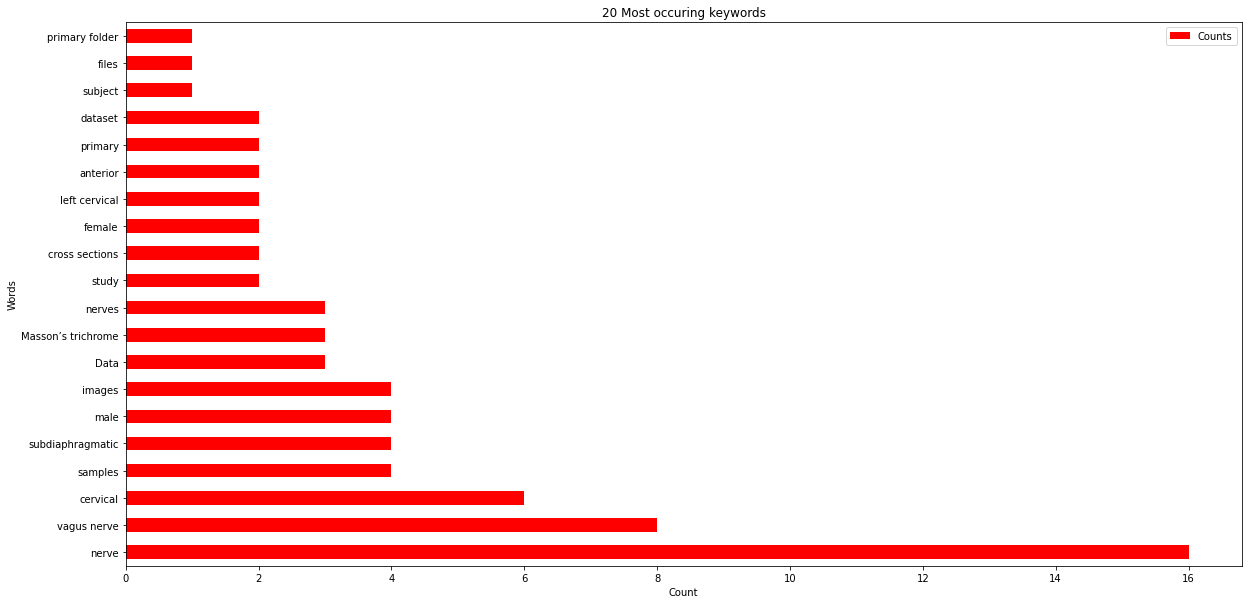

In [133]:
# Show plot of the keywords from output.json data  using horizontal bars like this: https://cdn.fightforsmall.com/depictdatastudio.com/2017/01/Depict-Data-Studio_Bar-Charts_Vertical-or-Horizontal_Horizontal-1.jpg 


key_words= {'Words':list(data["keywords"].keys()), 'Counts':list(data["keywords"].values())}
key_words = pd.DataFrame(key_words).set_index("Words")
plot = key_words.plot.barh(color="red")
plot.set_xlabel("Count")
plot.set_title("20 Most occuring keywords")


## Abstract

In [7]:
# Show the correlation matrix from output.json data

Text(0.5, 1.0, 'Correlation Matrix')

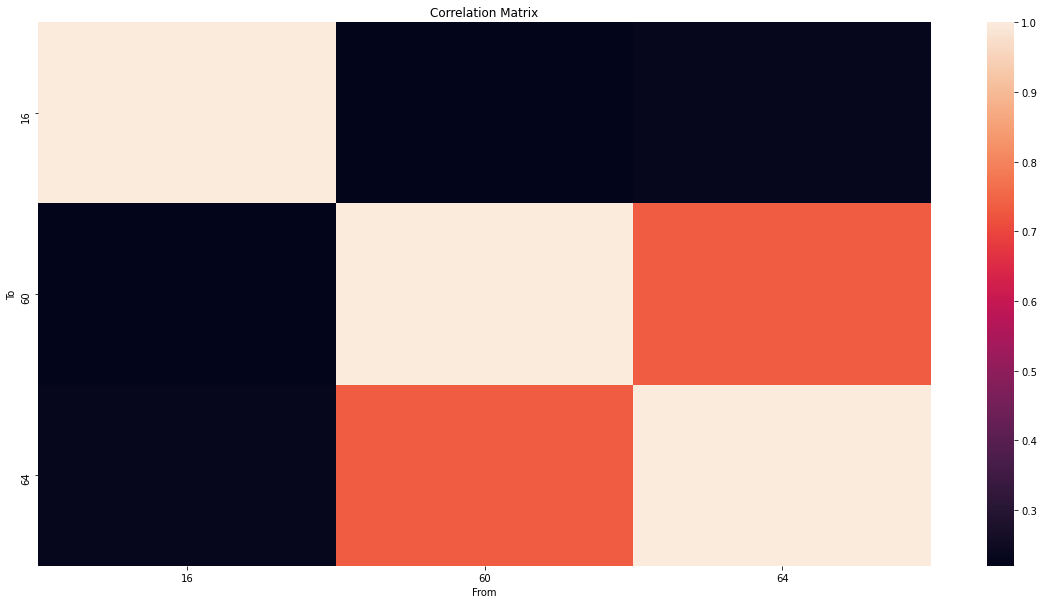

In [134]:
plot = sns.heatmap(pd.read_json(data["correlation_matrix"]))
plot.set_xlabel("From")
plot.set_ylabel("To")
plot.set_title("Correlation Matrix")

In [44]:
# Show seaborntract text from output.json data
data["abstract"]

"To quantify pig vagus nerve morphology Using micrographs of pig vagus nerve cross sections that were stained with Masson’s trichrome, we quantified effective nerve and fascicle diameters, as well as the number of fascicles at the cervical and subdiaphragmatic levels. Filepaths in the code are set to work as-is, in-place in the dataset.Part 1: AnalyzeAllSamples.m- Load binary TIF images for samples listed in Excel files.- Use polyarea to calculate cross-sectional area of each inner perineurium trace, outer perineurium trace [not for pig MT samples], and nerve trace.- Calculate the morphology metrics of interest (effective nerve diameter, effective fascicle diameter, perineurium thickness, ...).- Save the morphology metrics to .mat files.NOTE: Scale bar length hard-coded as 500 um.Part 2: DataExtraction_v3.m- Load the morphology metrics into data structures.Part 3: DataPlotting_v4.m- DataExtraction_v3.m must be called first to load the data.- Plot and save the nerve morphology metrics. 

## Data Plots

In [9]:
# Plot using matlab_output.xlsx , plot all the sheets that include the word "Plot" in their name

In [3]:
import plotly.express as px

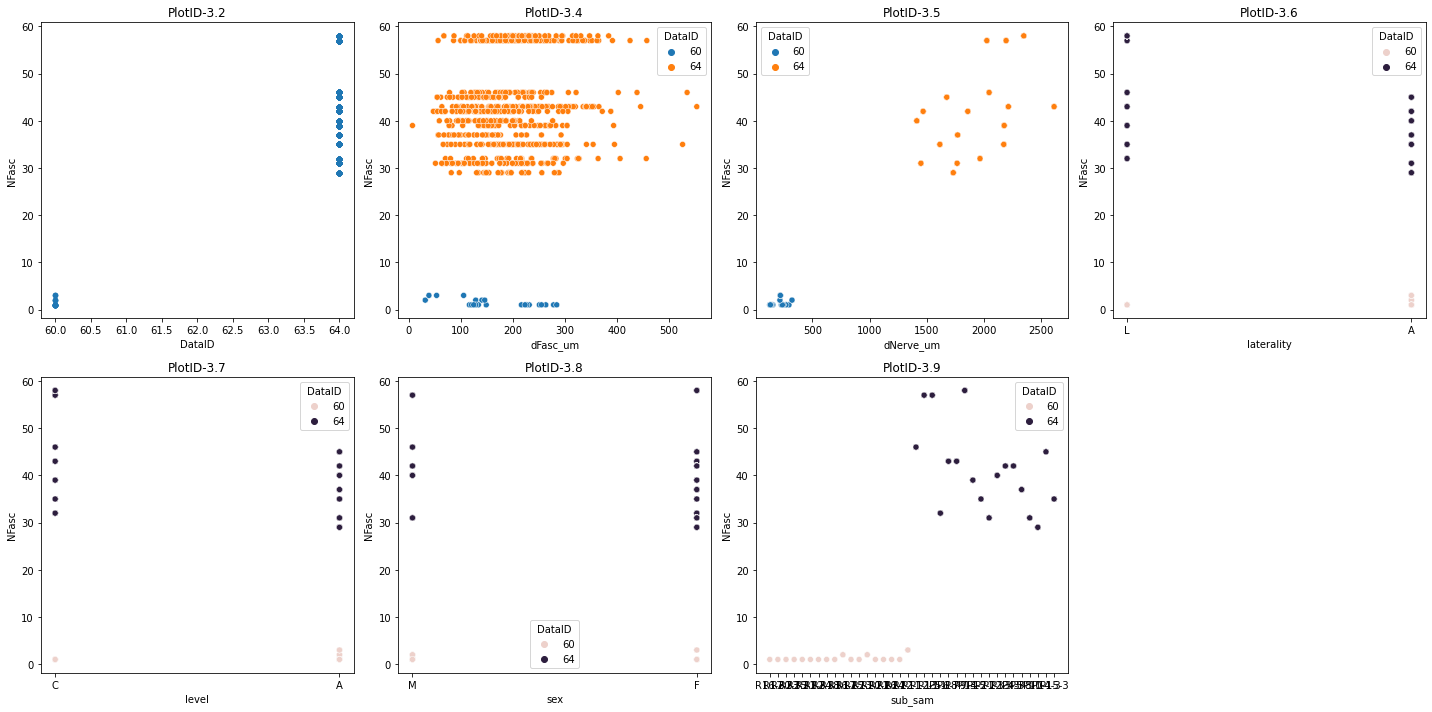

In [103]:
rcParams["figure.figsize"] = 20,10

plt3_2 = pd.read_excel("/home/devil/Documents/Tools/KnowMore/static/notebook-output/matlab_output.xlsx",sheet_name="PlotID-3.2")
plt3_4 = pd.read_excel("/home/devil/Documents/Tools/KnowMore/static/notebook-output/matlab_output.xlsx",sheet_name="PlotID-3.4")
plt3_4["DataID"] = plt3_4["DataID"].apply(str)
plt3_5 = pd.read_excel("/home/devil/Documents/Tools/KnowMore/static/notebook-output/matlab_output.xlsx",sheet_name="PlotID-3.5")
plt3_5["DataID"] = plt3_5["DataID"].apply(str)
plt3_6 = pd.read_excel("/home/devil/Documents/Tools/KnowMore/static/notebook-output/matlab_output.xlsx",sheet_name="PlotID-3.6")
plt3_7 = pd.read_excel("/home/devil/Documents/Tools/KnowMore/static/notebook-output/matlab_output.xlsx",sheet_name="PlotID-3.7")
plt3_8 = pd.read_excel("/home/devil/Documents/Tools/KnowMore/static/notebook-output/matlab_output.xlsx",sheet_name="PlotID-3.8")
plt3_9 = pd.read_excel("/home/devil/Documents/Tools/KnowMore/static/notebook-output/matlab_output.xlsx",sheet_name="PlotID-3.9")
fig, axs = plt.subplots(2, 4)
plt3_2.plot.scatter(x="DataID", y="NFasc", ax= axs[0,0])
axs[0,0].set_title("PlotID-3.2")
sns.scatterplot(data=plt3_4,x="dFasc_um", y="NFasc", hue="DataID", ax=axs[0,1])
axs[0,1].set_title("PlotID-3.4")
sns.scatterplot(data=plt3_5,x="dNerve_um", y="NFasc", hue="DataID", ax=axs[0,2])
axs[0,2].set_title("PlotID-3.5")
sns.scatterplot(data=plt3_6,x="laterality", y="NFasc", hue="DataID", ax=axs[0,3])
axs[0,3].set_title("PlotID-3.6")
sns.scatterplot(data=plt3_7,x="level", y="NFasc", hue="DataID", ax=axs[1,0])
axs[1,0].set_title("PlotID-3.7")
sns.scatterplot(data=plt3_8,x="sex", y="NFasc", hue="DataID", ax=axs[1,1])
axs[1,1].set_title("PlotID-3.8")
sns.scatterplot(data=plt3_9,x="sub_sam", y="NFasc", hue="DataID", ax=axs[1,2])
axs[1,2].set_title("PlotID-3.9")
fig.delaxes(axs[1,3])
fig.tight_layout()

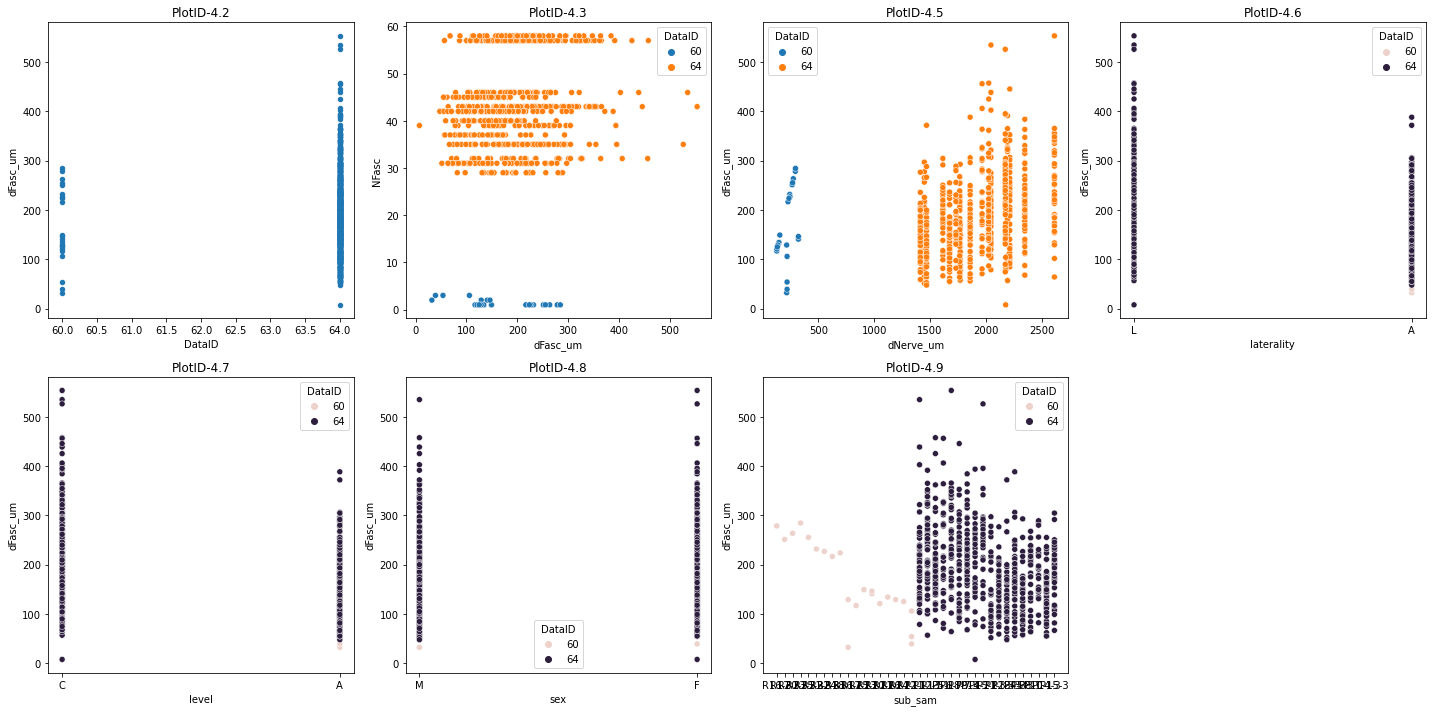

In [121]:

plt4_2 = pd.read_excel("/home/devil/Documents/Tools/KnowMore/static/notebook-output/matlab_output.xlsx",sheet_name="PlotID-4.2")
plt4_3 = pd.read_excel("/home/devil/Documents/Tools/KnowMore/static/notebook-output/matlab_output.xlsx",sheet_name="PlotID-4.3")
plt4_3["DataID"] = plt4_3["DataID"].apply(str)
plt4_5 = pd.read_excel("/home/devil/Documents/Tools/KnowMore/static/notebook-output/matlab_output.xlsx",sheet_name="PlotID-4.5")
plt4_5["DataID"] = plt4_5["DataID"].apply(str)
plt4_6 = pd.read_excel("/home/devil/Documents/Tools/KnowMore/static/notebook-output/matlab_output.xlsx",sheet_name="PlotID-4.6")
plt4_7 = pd.read_excel("/home/devil/Documents/Tools/KnowMore/static/notebook-output/matlab_output.xlsx",sheet_name="PlotID-4.7")
plt4_8 = pd.read_excel("/home/devil/Documents/Tools/KnowMore/static/notebook-output/matlab_output.xlsx",sheet_name="PlotID-4.8")
plt4_9 = pd.read_excel("/home/devil/Documents/Tools/KnowMore/static/notebook-output/matlab_output.xlsx",sheet_name="PlotID-4.9")
fig, axs = plt.subplots(2, 4)
plt4_2.plot.scatter(x="DataID", y="dFasc_um", ax= axs[0,0])
axs[0,0].set_title("PlotID-4.2")
sns.scatterplot(data=plt4_3,x="dFasc_um", y="NFasc", hue="DataID", ax=axs[0,1])
axs[0,1].set_title("PlotID-4.3")
sns.scatterplot(data=plt4_5,x="dNerve_um", y="dFasc_um", hue="DataID", ax=axs[0,2])
axs[0,2].set_title("PlotID-4.5")
sns.scatterplot(data=plt4_6,x="laterality", y="dFasc_um", hue="DataID", ax=axs[0,3])
axs[0,3].set_title("PlotID-4.6")
sns.scatterplot(data=plt4_7,x="level", y="dFasc_um", hue="DataID", ax=axs[1,0])
axs[1,0].set_title("PlotID-4.7")
sns.scatterplot(data=plt4_8,x="sex", y="dFasc_um", hue="DataID", ax=axs[1,1])
axs[1,1].set_title("PlotID-4.8")
sns.scatterplot(data=plt4_9,x="sub_sam", y="dFasc_um", hue="DataID", ax=axs[1,2])
axs[1,2].set_title("PlotID-4.9")
fig.delaxes(axs[1,3])
fig.tight_layout()

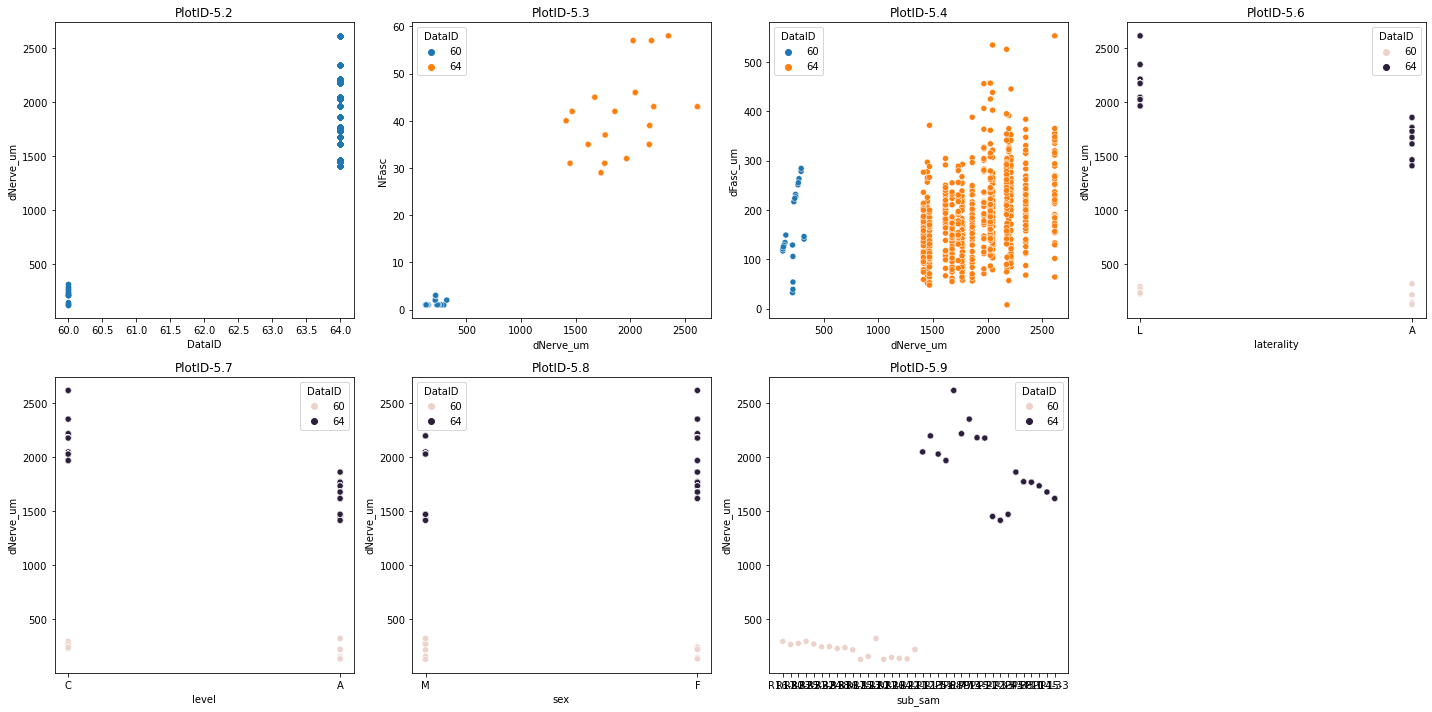

In [132]:
plt5_2 = pd.read_excel("/home/devil/Documents/Tools/KnowMore/static/notebook-output/matlab_output.xlsx",sheet_name="PlotID-5.2")
plt5_3 = pd.read_excel("/home/devil/Documents/Tools/KnowMore/static/notebook-output/matlab_output.xlsx",sheet_name="PlotID-5.3")
plt5_3["DataID"] = plt5_3["DataID"].apply(str)
plt5_4 = pd.read_excel("/home/devil/Documents/Tools/KnowMore/static/notebook-output/matlab_output.xlsx",sheet_name="PlotID-5.4")
plt5_4["DataID"] = plt5_4["DataID"].apply(str)
plt5_6 = pd.read_excel("/home/devil/Documents/Tools/KnowMore/static/notebook-output/matlab_output.xlsx",sheet_name="PlotID-5.6")
plt5_7 = pd.read_excel("/home/devil/Documents/Tools/KnowMore/static/notebook-output/matlab_output.xlsx",sheet_name="PlotID-5.7")
plt5_8 = pd.read_excel("/home/devil/Documents/Tools/KnowMore/static/notebook-output/matlab_output.xlsx",sheet_name="PlotID-5.8")
plt5_9 = pd.read_excel("/home/devil/Documents/Tools/KnowMore/static/notebook-output/matlab_output.xlsx",sheet_name="PlotID-5.9")
fig, axs = plt.subplots(2, 4)
plt5_2.plot.scatter(x="DataID", y="dNerve_um", ax= axs[0,0])
axs[0,0].set_title("PlotID-5.2")
sns.scatterplot(data=plt5_3,x="dNerve_um", y="NFasc", hue="DataID", ax=axs[0,1])
axs[0,1].set_title("PlotID-5.3")
sns.scatterplot(data=plt5_4,x="dNerve_um", y="dFasc_um", hue="DataID", ax=axs[0,2])
axs[0,2].set_title("PlotID-5.4")
sns.scatterplot(data=plt5_6,x="laterality", y="dNerve_um", hue="DataID", ax=axs[0,3])
axs[0,3].set_title("PlotID-5.6")
sns.scatterplot(data=plt5_7,x="level", y="dNerve_um", hue="DataID", ax=axs[1,0])
axs[1,0].set_title("PlotID-5.7")
sns.scatterplot(data=plt5_8,x="sex", y="dNerve_um", hue="DataID", ax=axs[1,1])
axs[1,1].set_title("PlotID-5.8")
sns.scatterplot(data=plt5_9,x="sub_sam", y="dNerve_um", hue="DataID", ax=axs[1,2])
axs[1,2].set_title("PlotID-5.9")
fig.delaxes(axs[1,3])
fig.tight_layout()